In [1]:
import scCube
from scCube import scCube
from scCube.visualization import *
from scCube.utils import *
from matplotlib.pyplot import rc_context
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

/slurm/home/yrd/fanlab/qianjingyang/.conda/envs/sccube/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = scCube()

In [3]:
# adata and model are downloaded from https://github.com/ZJUFanLab/scCube/blob/main/tutorial/statistics.md
sc_adata = sc.read_h5ad('../response/subtype/data/MCA_mouse_PeripheralBlood_3/MCA_mouse_PeripheralBlood_3_adata.h5ad')

In [4]:
generate_sc_meta, generate_sc_data = model.load_vae_and_generate_cell(
    sc_adata=sc_adata,
    celltype_key='Cell_type',
    cell_key='Cell',
    target_num=None,
    hidden_size=128,
    load_path='../response/subtype/data/MCA_mouse_PeripheralBlood_3/MCA_mouse_PeripheralBlood_3_epoch10000.pth',
    used_device='cuda:1')

generating by the proportion of cell types of the input scRNA-seq data...
loading model from ../response/subtype/data/MCA_mouse_PeripheralBlood_3/MCA_mouse_PeripheralBlood_3_epoch10000.pth
vae loading done!


Generate Epoch: 0: 100%|██████████| 3183/3183 [00:00<00:00, 16471.14it/s]

generated done!


data have been prepared!


In [5]:
generate_sc_meta['Cell_subtype'] =generate_sc_meta['Cell_type']
generate_sc_meta.Cell_subtype.value_counts()

B cell_Ly6d high(Peripheral_Blood)            998
T cell_Trbc2 high(Peripheral_Blood)           980
Macrophage_S100a4 high(Peripheral_Blood)      536
Neutrophil_Il1b high(Peripheral_Blood)        329
NK cell_Gzma high(Peripheral_Blood)           163
Macrophage_Ace high(Peripheral_Blood)         150
Erythroblast_Hba-a2 high(Peripheral_Blood)     17
Neutrophil_Retnlg high(Peripheral_Blood)       10
Name: Cell_subtype, dtype: int64

In [6]:
Neutrophil_list = ['Neutrophil_Il1b high(Peripheral_Blood)', 'Neutrophil_Retnlg high(Peripheral_Blood)']
Macrophage_list = ['Macrophage_S100a4 high(Peripheral_Blood)', 'Macrophage_Ace high(Peripheral_Blood)']

generate_sc_meta.loc[generate_sc_meta['Cell_type'].isin(Neutrophil_list), 'Cell_type'] = 'Neutrophil(Peripheral_Blood)'
generate_sc_meta.loc[generate_sc_meta['Cell_type'].isin(Macrophage_list), 'Cell_type'] = 'Macrophage(Peripheral_Blood)'

generate_sc_meta.Cell_type.value_counts()

B cell_Ly6d high(Peripheral_Blood)            998
T cell_Trbc2 high(Peripheral_Blood)           980
Macrophage(Peripheral_Blood)                  686
Neutrophil(Peripheral_Blood)                  339
NK cell_Gzma high(Peripheral_Blood)           163
Erythroblast_Hba-a2 high(Peripheral_Blood)     17
Name: Cell_type, dtype: int64

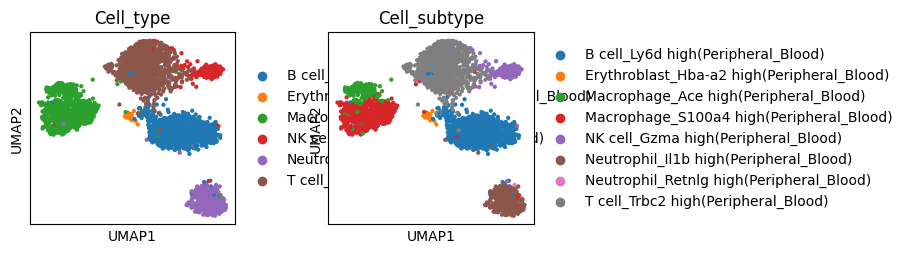

In [7]:
sc_adata_generate = model.pre_process(sc_data=generate_sc_data, 
                                      sc_meta=generate_sc_meta,
                                      is_normalized=True)

sc.pp.highly_variable_genes(sc_adata_generate, flavor="seurat_v3", n_top_genes=2000)
sc_adata_generate = sc_adata_generate[:, sc_adata_generate.var.highly_variable]
sc.pp.scale(sc_adata_generate, max_value=10)
sc.tl.pca(sc_adata_generate, svd_solver='arpack')
sc.pp.neighbors(sc_adata_generate)
sc.tl.umap(sc_adata_generate)

with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(sc_adata_generate, color=['Cell_type', 'Cell_subtype'])

In [8]:
generate_sc_data_new, generate_sc_meta_new = model.generate_pattern_random(
    generate_sc_data=generate_sc_data,
    generate_sc_meta=generate_sc_meta,
    celltype_key='Cell_type',
    set_seed=True,
    seed=12345,
    spatial_cell_type=None,
    spatial_dim=2,
    spatial_size=50,
    delta=20,
    lamda=1,)

generating spatial coordinates of single cells...
generating spatial patterns of totally 6 cell types...


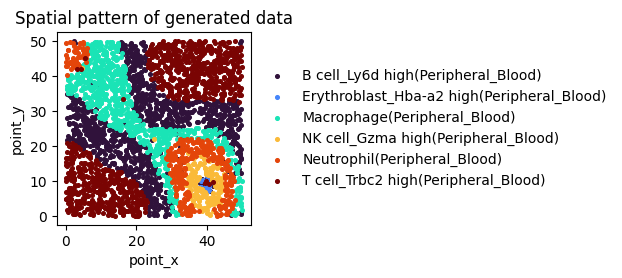

In [9]:
# spatial patterns for cell types
plot_spatial_pattern_scatter(
    obj=generate_sc_meta_new,
    figwidth=2.5,
    figheight=2.5,
    dim=2,
    x="point_x",
    y="point_y",
    label='Cell_type',
    palette=['#30123b', '#4685fa', '#1ae4b6', '#faba39', '#e4450a', '#7a0403'],
    colormap='turbo',
    size=7,
    alpha=1)
plt.show()

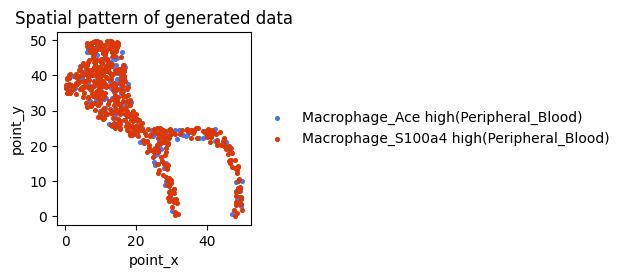

In [10]:
# default (not consider generating spatial patterns for cell subtypes)
generate_meta_sub_default = generate_sc_meta_new[generate_sc_meta_new['Cell_type'] == 'Macrophage(Peripheral_Blood)']
generate_data_sub_default = generate_sc_data[generate_meta_sub_default.index]
plot_spatial_pattern_scatter(
    obj=generate_meta_sub_default,
    figwidth=2.5,
    figheight=2.5,
    dim=2,
    x="point_x",
    y="point_y",
    label='Cell_subtype',
    palette=['#4776ee', '#da3907'],
    colormap='turbo',
    size=7,
    alpha=1)
plt.show()

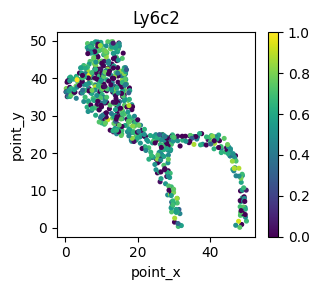

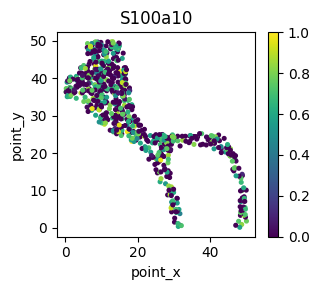

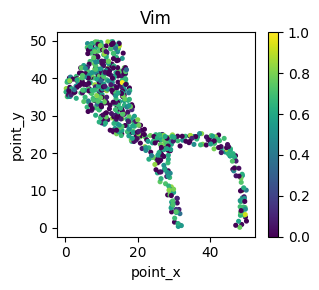

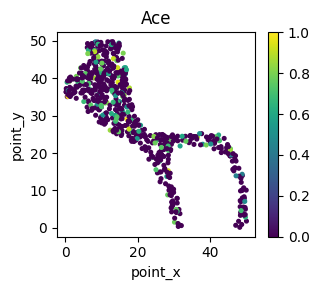

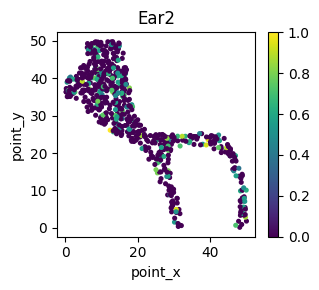

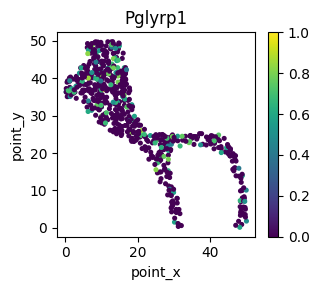

In [11]:
for gene in ['Ly6c2', 'S100a10', 'Vim', 'Ace', 'Ear2', 'Pglyrp1']:
    plot_gene_scatter(
        data=generate_data_sub_default,
        obj=generate_meta_sub_default,
        figwidth=3.3,
        figheight=3,
        dim=2,
        label='Cell',
        normalize=True,
        x="point_x",
        y="point_y",
        show_gene=gene,
        colormap='viridis',
        size=7,
        alpha=1)
    plt.show()

In [12]:
# consider generating spatial patterns for cell subtypes
generate_data_sub_new, generate_meta_sub_new = model.generate_subtype_pattern_random(
    generate_sc_data=generate_sc_data_new,
    generate_sc_meta=generate_sc_meta_new,
    set_seed=True,
    seed=12345,
    celltype_key='Cell_type',
    select_cell_type='Macrophage(Peripheral_Blood)',
    subtype_key='Cell_subtype',
    spatial_dim=2,
    subtype_delta=30,)

generating subtype spatial patterns of Macrophage(Peripheral_Blood) ...


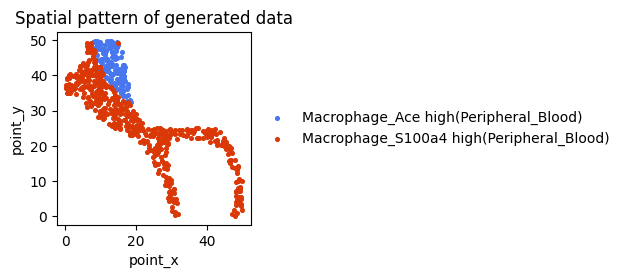

In [13]:
plot_spatial_pattern_scatter(
    obj=generate_meta_sub_new,
    figwidth=2.5,
    figheight=2.5,
    dim=2,
    x="point_x",
    y="point_y",
    label='Cell_subtype',
    palette=['#4776ee', '#da3907'],
    colormap='turbo',
    size=7,
    alpha=1)
plt.show()

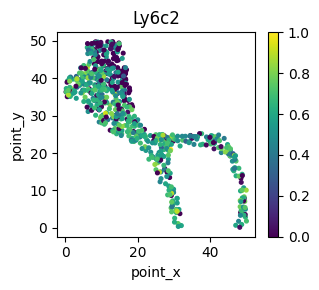

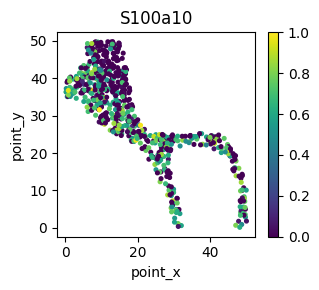

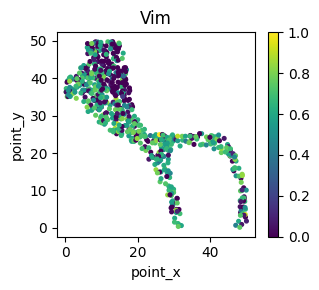

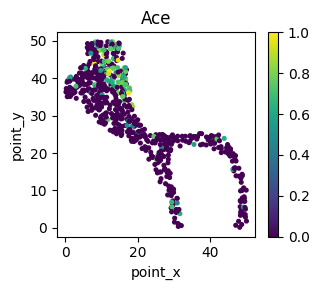

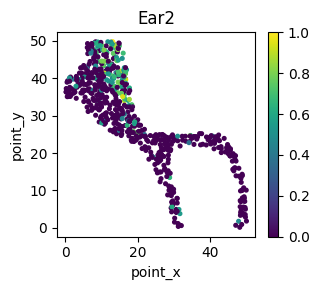

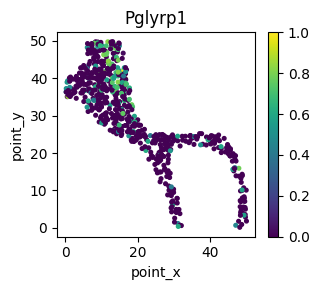

In [14]:
for gene in ['Ly6c2', 'S100a10', 'Vim', 'Ace', 'Ear2', 'Pglyrp1']:
    plot_gene_scatter(
        data=generate_data_sub_new,
        obj=generate_meta_sub_new,
        figwidth=3.3,
        figheight=3,
        dim=2,
        label='Cell',
        normalize=True,
        x="point_x",
        y="point_y",
        show_gene=gene,
        colormap='viridis',
        size=7,
        alpha=1)
    plt.show()